In [1]:
# pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
from keras.applications import vgg19
from keras import Sequential
from keras import Model
from keras.layers import Layer, Add, InputSpec, Activation, Conv2D, UpSampling2D, Input, Concatenate, InputLayer, Flatten
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras_contrib.layers import InstanceNormalization
from keras.models import load_model
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import glob
import datetime
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)

mean_squared_error = tf.keras.losses.MeanSquaredError()

Using TensorFlow backend.
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framewo

# Model

In [3]:
class VGG19(object):

    def __init__(self):
        vgg_layers = vgg19.VGG19(weights='imagenet').layers
        self.model = Model(inputs = [vgg_layers[0].input], 
                           outputs = [vgg_layers[2].output, vgg_layers[5].output, 
                                      vgg_layers[10].output, vgg_layers[15].output])
        self.vgg_layers = vgg_layers
        for layer in self.model.layers:
            layer.trainable = False

    def __call__(self, X):
        res = self.model(X)
        return res

In [4]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3]

    def call(self, x):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

In [5]:
class ConvLayer(object):
    def __init__(self, out_channels, kernel_size, stride, **kwargs):
        reflection_padding = kernel_size // 2
        
        self.reflection_pad = ReflectionPadding2D((reflection_padding, reflection_padding))
        self.conv2d = Conv2D(out_channels, kernel_size = kernel_size, strides = stride)

    def __call__(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [6]:
class ResidualBlock(object):
    def __init__(self, channels):
        self.conv1 = ConvLayer(channels, kernel_size=3, stride=1)
        self.in1 = InstanceNormalization(3)
        self.conv2 = ConvLayer(channels, kernel_size=3, stride=1)
        self.in2 = InstanceNormalization(3)
        self.relu = Activation('relu')
        self.add = Add()

    def __call__(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = self.add([out, x])
        return out

In [7]:
class UpsampleConvLayer(object):
    def __init__(self, out_channels, kernel_size, stride, upsample):   
        self.upsample_layer = UpSampling2D(upsample)
        self.conv = ConvLayer(out_channels, kernel_size=kernel_size, stride=stride)
    
    def __call__(self, x):
        out = self.upsample_layer(x)
        out = self.conv(out)
        return out

In [8]:
class StylizerNet(object):
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ConvLayer(32, kernel_size=9, stride=1)
        self.in1 = InstanceNormalization(3)
        self.conv2 = ConvLayer(64, kernel_size=3, stride=2)
        self.in2 = InstanceNormalization(3)
        self.conv3 = ConvLayer(128, kernel_size=3, stride=2)
        self.in3 = InstanceNormalization(3)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(64, kernel_size=3, stride=1, upsample=2)
        self.in4 = InstanceNormalization(3)
        self.deconv2 = UpsampleConvLayer(32, kernel_size=3, stride=1, upsample=2)
        self.in5 = InstanceNormalization(3)
        self.deconv3 = ConvLayer(3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = Activation('relu')

    def __call__(self, x):
        y = self.relu(self.in1(self.conv1(x))) # 32
        y = self.relu(self.in2(self.conv2(y))) # 64
        y = self.relu(self.in3(self.conv3(y))) # 128
        
        y = self.res1(y) # 128
        y = self.res2(y) # 128
        y = self.res3(y) # 128
        y = self.res4(y) # 128
        y = self.res5(y) # 128
        
        y = self.relu(self.in4(self.deconv1(y))) 
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

# Helper functions

In [167]:
def showInRow(list_of_images):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [9]:
def load_image(file, img_size):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if (img.shape[0] < img.shape[1]):
        f = img_size * img.shape[1] // img.shape[0]
        img = cv2.resize(img, (f, img_size))
    else:
        f = img_size * img.shape[0] // img.shape[1]
        img = cv2.resize(img, (img_size, f))
    
    (h, w) = img.shape[:2]
    
    img = img[h // 2 - img_size//2 : h // 2 + img_size//2, w // 2 - img_size//2 : w // 2 + img_size//2]
    
    return img

# Model loss

In [10]:
def gram_matrix(y):
    shape = tf.shape(y)
    
    b = shape[0]
    h = shape[1]
    w = shape[2]
    ch = shape[3]
    
    features = tf.reshape(y, (b, w * h, ch))
    features_t = tf.transpose(features, (0, 2, 1))
    gram = tf.matmul(features_t, features) / tf.cast(ch * h * w, tf.float32)
    return gram

In [11]:
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = tf.reshape(tf.constant([0.485, 0.456, 0.406], dtype=tf.float32), (1, 1, 1, -1))
    std = tf.reshape(tf.constant([0.229, 0.224, 0.225], dtype=tf.float32), (1, 1, 1, -1))
    batch = batch / 255.0
    return (batch - mean) / std

In [12]:
def transform(img):
    return tf.constant(np.array([img]), dtype=tf.float32)

### Loss function

In [41]:
def get_loss():
    vgg = VGG19()
    style_image = load_image(STYLE_IMAGE, IMG_SIZE)
    style_image = transform(style_image) # (1, h, w, ch)

    style_image = K.repeat_elements(style_image, BATCH_SIZE, 0)
    feat_style = vgg(normalize_batch(style_image))
    gram_style = [gram_matrix(y) for y in feat_style] # [(1, ch, ch)]
    
    def loss(y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        feat_true = vgg(normalize_batch(y_true))
        feat_pred = vgg(normalize_batch(y_pred))
        
        content_loss = mean_squared_error(feat_true[2], feat_pred[2])
        
        style_loss = 0.0
        gram_pred = [gram_matrix(y) for y in feat_pred] # [(batch, ch, ch)]
        for gm_pred, gm_style in zip(gram_pred, gram_style):
            style_loss += mean_squared_error(gm_pred, gm_style[:batch_size])
        style_loss *= STYLE_WEIGHT
        
        tv_loss = TV_WEIGHT * (K.mean((y_pred[:,:,1:,:]-y_pred[:,:,:-1,:])**2)+K.mean((y_pred[:,1:,:,:]-y_pred[:,:-1,:,:])**2))
        
        total_loss = content_loss + tv_loss + style_loss
        return total_loss
    return loss

# Initialize and train model

### Model params

In [ ]:
STYLE_IMAGE = "styles/candy.jpg"
BATCH_SIZE = 16
IMG_SIZE = 224
STYLE_WEIGHT = 2000
TV_WEIGHT = 1e-5

In [42]:
stylizer_inp = Input((224, 224, 3))
stylizer = StylizerNet()(stylizer_inp)
stylizer = Model(stylizer_inp, stylizer)

In [43]:
stylizer.compile(loss=get_loss(), optimizer='adam')

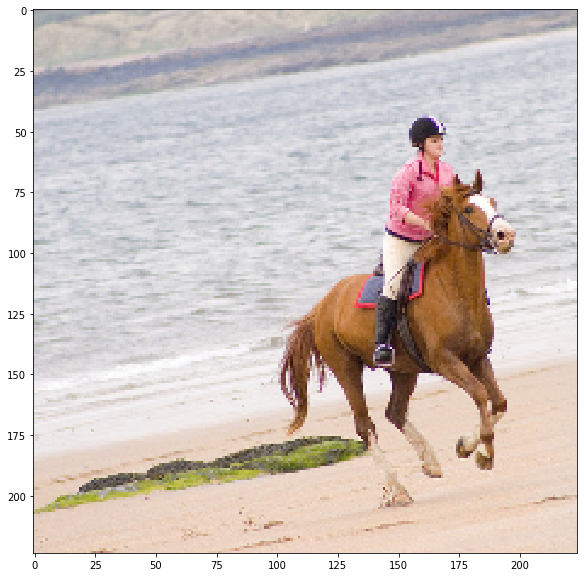

In [44]:
validation_img = np.array([load_image('train2017/000000515895.jpg', IMG_SIZE)])
plt.imshow(validation_img[0])

2019-10-29 19:20:05.920208 It: 0 out of 2501	loss: 33446.19140625


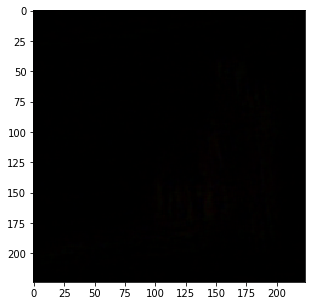

2019-10-29 19:20:41.112249 It: 50 out of 2501	loss: 7789.54736328125
2019-10-29 19:21:07.657011 It: 100 out of 2501	loss: 4434.2578125
2019-10-29 19:21:34.205646 It: 150 out of 2501	loss: 3599.187255859375
2019-10-29 19:22:00.742665 It: 200 out of 2501	loss: 2999.92333984375
2019-10-29 19:22:27.207336 It: 250 out of 2501	loss: 2676.06640625
2019-10-29 19:22:53.634355 It: 300 out of 2501	loss: 2390.04296875
2019-10-29 19:23:20.145419 It: 350 out of 2501	loss: 2164.55419921875
2019-10-29 19:23:46.675530 It: 400 out of 2501	loss: 2037.3558349609375
2019-10-29 19:24:13.323871 It: 450 out of 2501	loss: 2026.0377197265625
2019-10-29 19:24:39.963496 It: 500 out of 2501	loss: 1904.38916015625


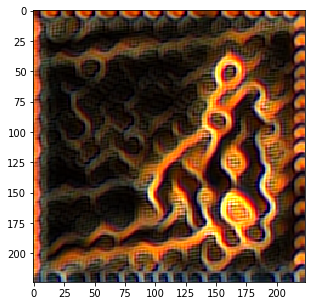

2019-10-29 19:25:06.922835 It: 550 out of 2501	loss: 1812.4969482421875
2019-10-29 19:25:33.529924 It: 600 out of 2501	loss: 1731.149658203125
2019-10-29 19:26:00.115461 It: 650 out of 2501	loss: 1663.413330078125
2019-10-29 19:26:26.657004 It: 700 out of 2501	loss: 1688.973876953125
2019-10-29 19:26:53.274122 It: 750 out of 2501	loss: 1570.7818603515625
2019-10-29 19:27:19.892919 It: 800 out of 2501	loss: 1645.730224609375
2019-10-29 19:27:46.543845 It: 850 out of 2501	loss: 1580.2940673828125
2019-10-29 19:28:13.093449 It: 900 out of 2501	loss: 1521.0655517578125
2019-10-29 19:28:39.710475 It: 950 out of 2501	loss: 1547.9512939453125
2019-10-29 19:29:06.391190 It: 1000 out of 2501	loss: 1478.29296875


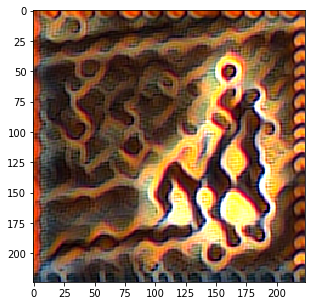

2019-10-29 19:29:33.304215 It: 1050 out of 2501	loss: 1452.5657958984375
2019-10-29 19:29:59.801524 It: 1100 out of 2501	loss: 1488.853759765625
2019-10-29 19:30:26.405942 It: 1150 out of 2501	loss: 1425.7864990234375
2019-10-29 19:30:53.055220 It: 1200 out of 2501	loss: 1444.162353515625
2019-10-29 19:31:19.635659 It: 1250 out of 2501	loss: 1475.9578857421875
2019-10-29 19:31:46.448457 It: 1300 out of 2501	loss: 1353.6856689453125
2019-10-29 19:32:13.534885 It: 1350 out of 2501	loss: 1374.2734375
2019-10-29 19:32:40.114749 It: 1400 out of 2501	loss: 1408.3828125
2019-10-29 19:33:06.720020 It: 1450 out of 2501	loss: 1362.5523681640625
2019-10-29 19:33:33.311607 It: 1500 out of 2501	loss: 1297.884521484375


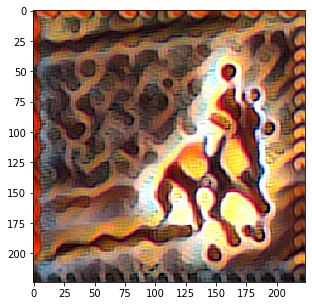

2019-10-29 19:34:00.230178 It: 1550 out of 2501	loss: 1324.6622314453125
2019-10-29 19:34:26.901594 It: 1600 out of 2501	loss: 1347.611328125
2019-10-29 19:34:53.537115 It: 1650 out of 2501	loss: 1406.52880859375
2019-10-29 19:35:20.157658 It: 1700 out of 2501	loss: 1332.3033447265625
2019-10-29 19:35:47.152002 It: 1750 out of 2501	loss: 1274.176513671875
2019-10-29 19:36:13.625474 It: 1800 out of 2501	loss: 1213.344970703125
2019-10-29 19:36:40.215246 It: 1850 out of 2501	loss: 1252.121826171875
2019-10-29 19:37:06.817607 It: 1900 out of 2501	loss: 1234.0732421875
2019-10-29 19:37:33.315816 It: 1950 out of 2501	loss: 1316.5848388671875
2019-10-29 19:37:59.880760 It: 2000 out of 2501	loss: 1272.8892822265625


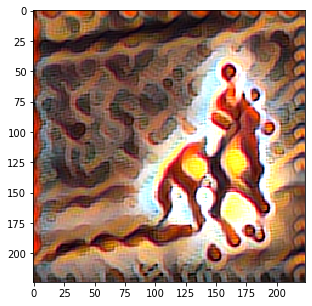

2019-10-29 19:38:26.842210 It: 2050 out of 2501	loss: 1202.8101806640625
2019-10-29 19:38:53.558542 It: 2100 out of 2501	loss: 1232.676025390625
2019-10-29 19:39:20.163527 It: 2150 out of 2501	loss: 1246.072998046875
2019-10-29 19:39:46.699273 It: 2200 out of 2501	loss: 1151.114990234375
2019-10-29 19:40:13.257364 It: 2250 out of 2501	loss: 1212.985107421875
2019-10-29 19:40:39.806882 It: 2300 out of 2501	loss: 1275.7529296875
2019-10-29 19:41:06.392702 It: 2350 out of 2501	loss: 1254.8995361328125
2019-10-29 19:41:32.930315 It: 2400 out of 2501	loss: 1253.05517578125
2019-10-29 19:41:59.516540 It: 2450 out of 2501	loss: 1237.4122314453125
2019-10-29 19:42:26.111950 It: 2500 out of 2501	loss: 1138.7664794921875


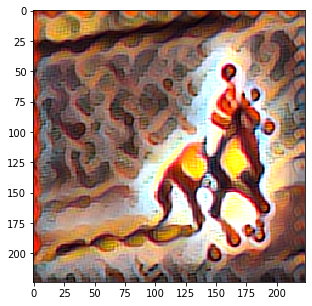

In [45]:
file_names = glob.glob('train2017/*.jpg')
n = 2501  # len(file_names) // BATCH_SIZE
plt.rcParams["figure.figsize"] = (16, 5) # (w, h)
for it in range(n):
    start = it * BATCH_SIZE
    end = (it + 1) * BATCH_SIZE
    samples = np.array([load_image(file_name, IMG_SIZE) for file_name in file_names[start:end]])
    loss = stylizer.train_on_batch(samples, samples)
    if it % 50 == 0:
        print(f'{datetime.datetime.now()} It: {it} out of {n}\tloss: {loss}')
    if it % 500 == 0:
        stylizer.save(f"models/model-{it}.ckpt")
        pred = stylizer.predict(validation_img)[0]
        clipped = np.clip(pred, 0, 255).astype(np.uint8)
        plt.imshow(clipped)
        plt.show()

# Save trained model

In [ ]:
stylizer.save('model-candy-style2k-b2500.ckpt')

# Load trained model

In [48]:
glob.glob('model/model-*.ckpt')

['model-candy-style2k-b2500.ckpt',
 'model-candy-style4k-b2500.ckpt',
 'model-feathers-style1000-b2500.ckpt',
 'model-feathers-style10k-b2500.ckpt',
 'model-feathers-style4k-b2500.ckpt',
 'model-lamuse-style4k-b2500.ckpt',
 'model-lamuse-style6k-b2500.ckpt',
 'model-starrynight-style6k-b2000.ckpt']

In [ ]:
stylizer.load_weights('model/model-lamuse-style6k-b2500.ckpt')

# Demo

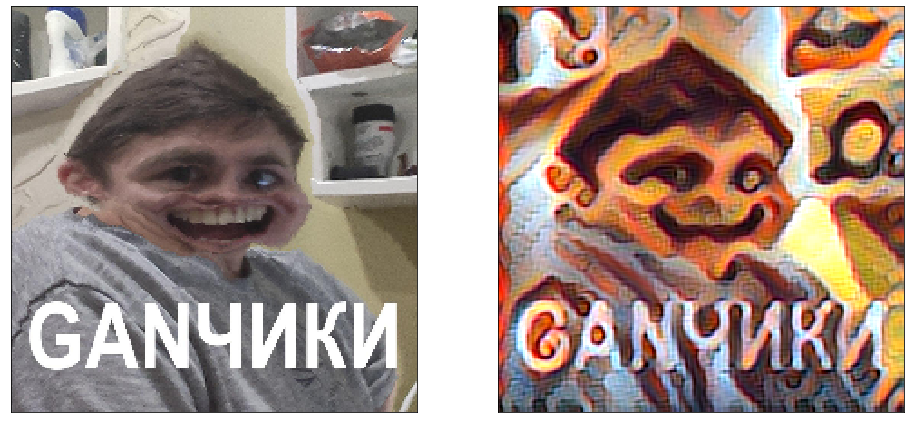

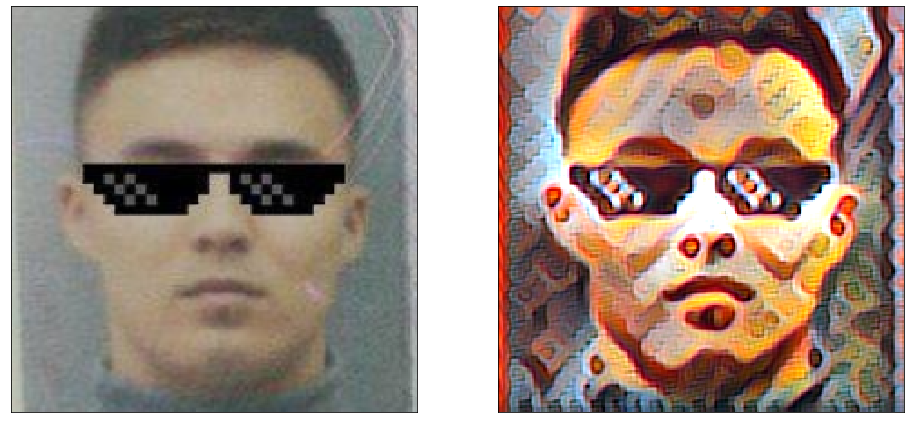

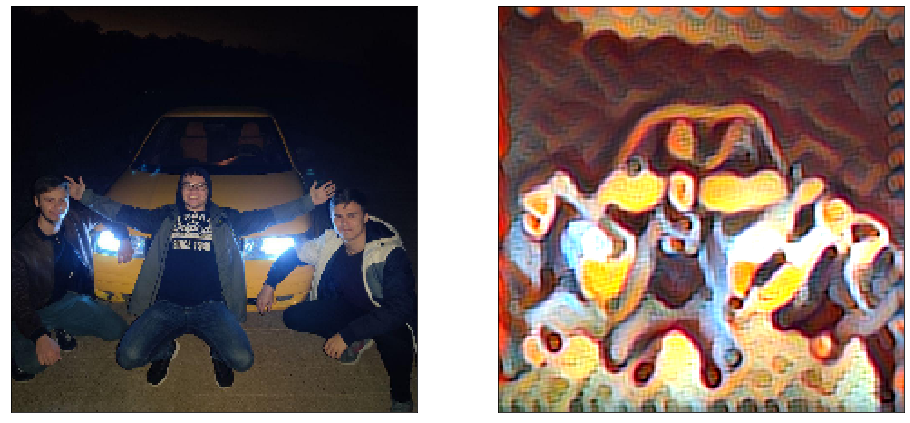

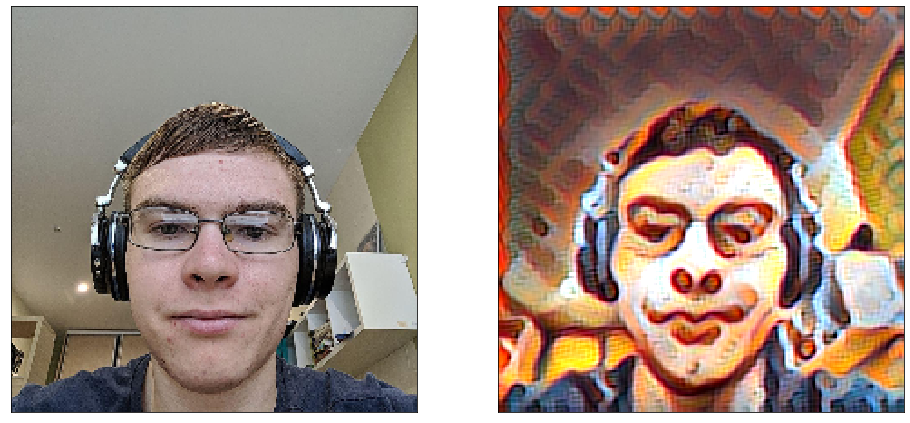

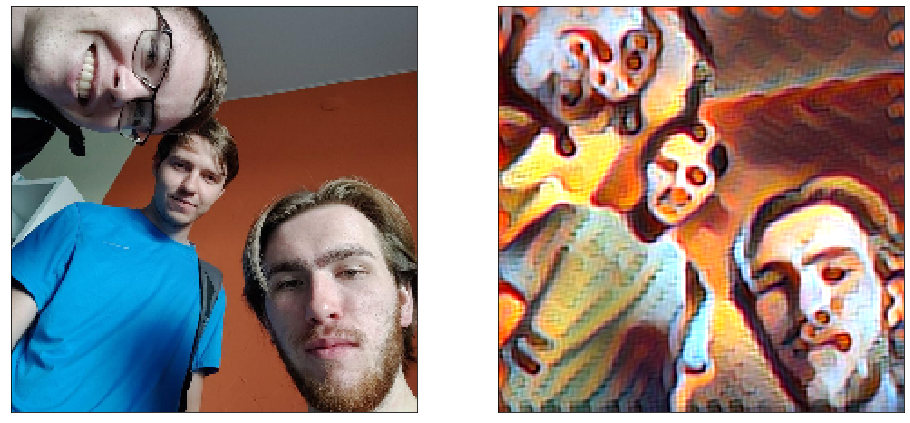

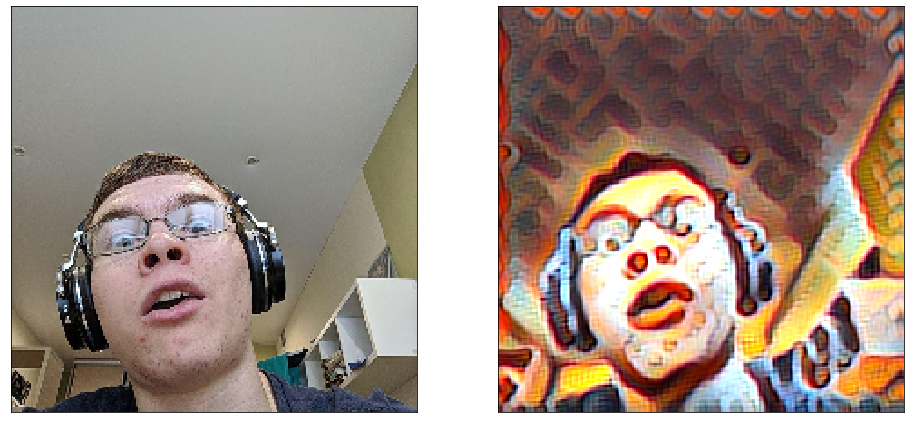

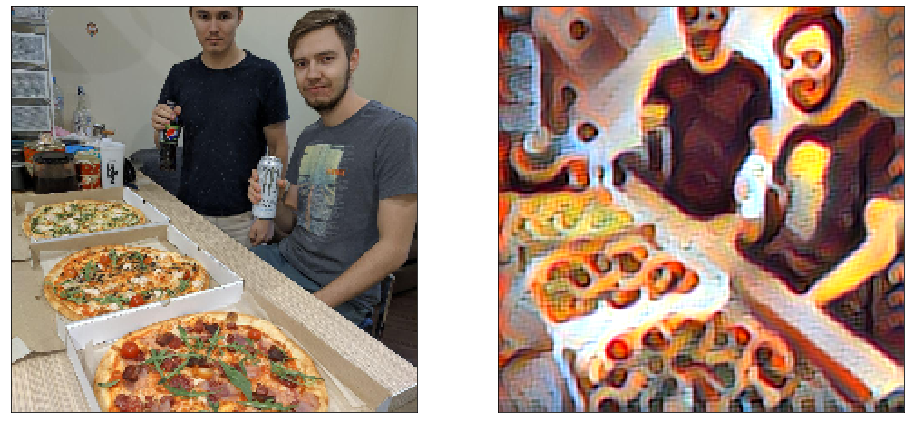

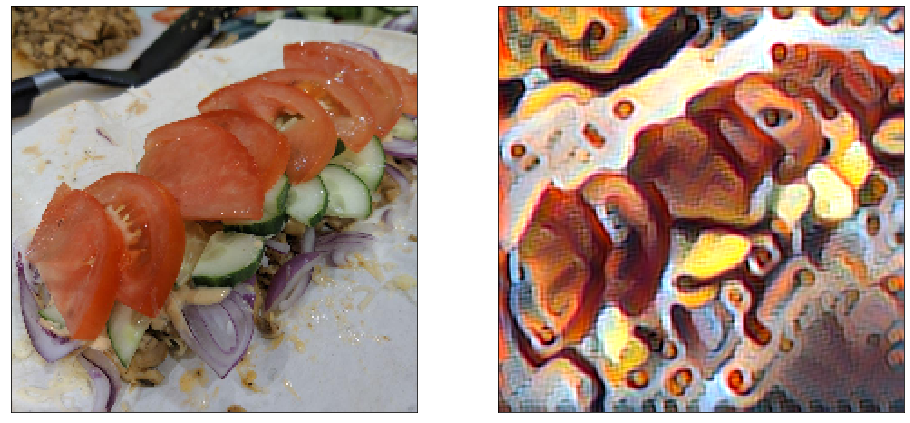

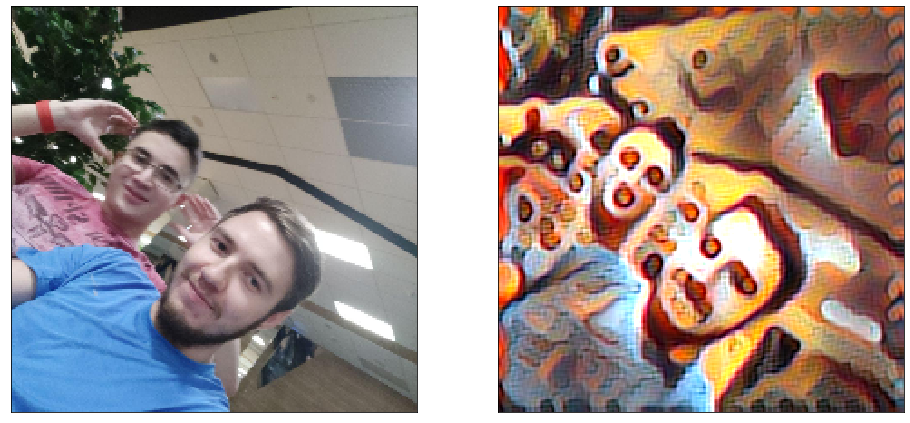

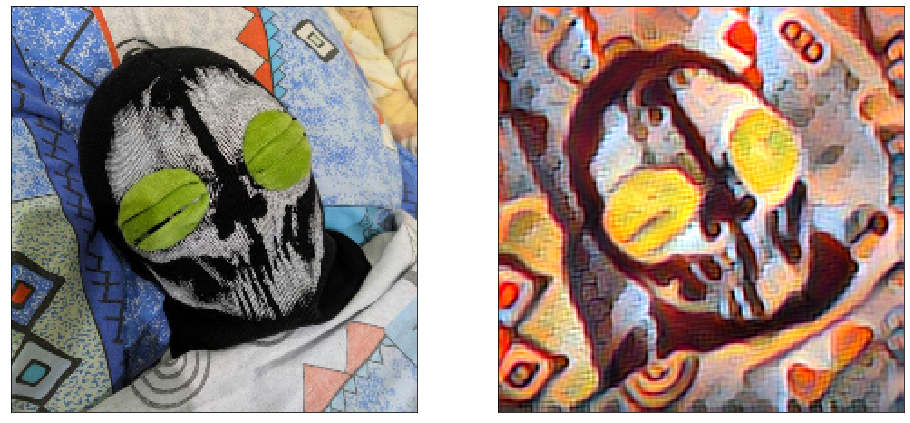

In [47]:
img_names = glob.glob('test/*')
imgs = np.array([load_image(f, IMG_SIZE) for f in img_names])
preds = stylizer.predict(imgs)

plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
for img, pred in zip(imgs, preds):
    pred = np.clip(pred, 0, 255).astype(np.uint8)
    showInRow([img, pred])